Epoch 0, Loss: 17.1367
Epoch 50, Loss: 2.3017
Epoch 100, Loss: 1.9823
Epoch 150, Loss: 1.9698
Epoch 200, Loss: 1.7930
Epoch 250, Loss: 1.7904
deep learning is powerful learning is


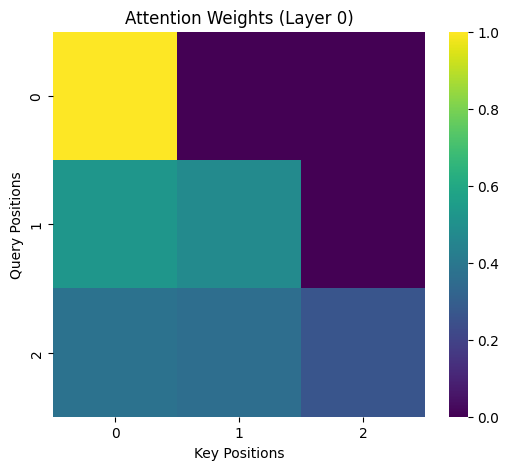

In [ ]:
# ================================
# MINI GPT IMPLEMENTATION (UPDATED)
# ================================

# -----------------------------
# Import required libraries
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Dataset (Increased Vocabulary)
# -----------------------------
sentences = [
    "deep learning is powerful",
    "deep learning is fun",
    "transformers are powerful",
    "attention is all you need",
    "deep models learn representations",
    "transformers use self attention"
]

# -----------------------------
# Step 2: Build Vocabulary
# -----------------------------
words = sorted(set(" ".join(sentences).split()))
vocab_size = len(words)

word2idx = {word: idx for idx, word in enumerate(words)}
idx2word = {idx: word for word, idx in word2idx.items()}

# -----------------------------
# Step 3: Encode Sentences
# -----------------------------
def encode(sentence):
    return [word2idx[word] for word in sentence.split()]

data = [encode(sentence) for sentence in sentences]

# -----------------------------
# Step 4: Hyperparameters
# -----------------------------
embed_dim = 32
num_heads = 4
num_layers = 2
max_len = 6
dropout = 0.1

# ============================================================
# Step 5: Masked Self-Attention (with Dropout + Weights)
# ============================================================
class MaskedSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout
        )

    def forward(self, x):
        seq_len = x.size(0)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        attn_out, attn_weights = self.attn(
            x, x, x, attn_mask=mask, need_weights=True
        )
        return attn_out, attn_weights

# ============================================================
# Step 6: GPT Decoder Block (GELU + Dropout)
# ============================================================
class GPTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.attn = MaskedSelfAttention(embed_dim, num_heads, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),                # GELU instead of ReLU
            nn.Dropout(dropout),
            nn.Linear(4 * embed_dim, embed_dim)
        )

        self.ln2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, attn_weights = self.attn(self.ln1(x))
        x = x + self.dropout(attn_out)
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x, attn_weights

# ============================================================
# Step 7: MiniGPT Model
# ============================================================
class MiniGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        self.blocks = nn.ModuleList(
            [GPTBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)]
        )

        self.ln = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(T)

        x = self.token_emb(x) + self.pos_emb(pos)
        x = x.transpose(0, 1)

        all_attn_weights = []

        for block in self.blocks:
            x, attn_weights = block(x)
            all_attn_weights.append(attn_weights)

        x = self.ln(x)
        x = x.transpose(0, 1)
        return self.fc(x), all_attn_weights

# ============================================================
# Step 8: Training Setup
# ============================================================
model = MiniGPT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(300):
    total_loss = 0
    for seq in data:
        x = torch.tensor(seq[:-1]).unsqueeze(0)
        y = torch.tensor(seq[1:]).unsqueeze(0)

        logits, _ = model(x)
        loss = loss_fn(
            logits.view(-1, vocab_size),
            y.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ============================================================
# Step 9: Text Generation
# ============================================================
def generate(start_word, max_new_tokens=5):
    model.eval()
    idx = torch.tensor([[word2idx[start_word]]])

    for _ in range(max_new_tokens):
        logits, _ = model(idx)
        next_token = torch.argmax(logits[:, -1, :], dim=-1)
        idx = torch.cat([idx, next_token.unsqueeze(0)], dim=1)

    return " ".join(idx2word[i.item()] for i in idx[0])

print(generate("deep"))

# ============================================================
# Step 10: Plot Attention Weights
# ============================================================
def plot_attention(attn_weights, layer=0):
    attn = attn_weights[layer][0].detach().numpy()
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn, cmap="viridis")
    plt.title(f"Attention Weights (Layer {layer})")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

# Run attention visualization
model.eval()
sample_input = torch.tensor(data[0][:-1]).unsqueeze(0)
_, attention_weights = model(sample_input)
plot_attention(attention_weights, layer=0)
